<h1>Sentiment Analysis Using LSTM</h1>

<h2>Importing libraries and loading the dataset</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from bs4 import BeautifulSoup
import re
import spacy
import emoji
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv"
df = pd.read_csv(file_path, header=None, names=['number', 'Border', 'label', 'message'])

<h2>Exploring the data</h2>

In [3]:
df.head()

,number,Border,label,message
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df['label'].value_counts()

label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [5]:
# Drop useless columns
df.drop(['number', 'Border'], axis=1, inplace=True)

In [6]:
df.shape

(74682, 2)

In [7]:
# Check for null
df.isnull().sum()

label        0
message    686
dtype: int64

In [8]:
# Drop null 
df.dropna(inplace=True)

In [9]:
df.shape

(73996, 2)

<h2>Preprocessing</h2>

<h3>Lower casing text</h3>

In [10]:
df['message'] = df['message'].str.lower()

In [11]:
df.head()

,label,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


<h3>Removing HTML tags</h3>

In [12]:
df['message'] = df['message'].apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())

<h3>Removing URLs</h3>

In [13]:
df['message'] = df['message'].apply(lambda text: re.sub(r'http\S+|www\S+', '', text))

<h3>Removing Punctuation</h3>

In [14]:
df['message'] = df['message'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

<h3>Removing Stop Words</h3>

In [15]:
nlp = spacy.load("en_core_web_sm")

df['message'] = df['message'].apply(lambda text: " ".join([token.text for token in nlp(text) if not token.is_stop]) if isinstance(text, str) else text)

<h3>Removing Emojis</h3>

In [16]:
df['message'] = df['message'].apply(lambda text: emoji.demojize(text))

<h3>Lemmatization</h3>

In [17]:
df['message_lemmatized'] = df['message'].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))

In [18]:
df.head()

,label,message,message_lemmatized
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland 2 murder


In [21]:
# Preprocessing the label
df['label'] = df['label'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

df['label'].value_counts()

label
2    30983
0    22358
1    20655
Name: count, dtype: int64

<h2>Split the data</h2>

In [22]:
X = df['message_lemmatized']
y= df['label']

In [23]:
X_train1 , X_test , y_train1 , y_test = train_test_split(X,y , random_state = 42 , test_size = 0.2  , shuffle = True)
X_train , X_val , y_train , y_val = train_test_split(X_train1 , y_train1 , random_state = 42 , test_size = 0.15  , shuffle = True)

In [24]:
X_train.shape , X_val.shape , X_test.shape , y_train.shape , y_val.shape , y_test.shape

((50316,), (8880,), (14800,), (50316,), (8880,), (14800,))

<h2>Tokenization</h2>

***Converting words into numerical tokens***

In [25]:
tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train) # we call this method to build the tokenizer on the train data only to avoid data leakage !

In [26]:
#  returns the total number of documents (sentences) processed by the tokenizer
tokenizer.document_count

50316

<h3>Conversion to sequence</h3>

***Convert each text in the data to sequences of integers based on the tokenizer's vocabulary***

In [27]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

<h3>Padding</h3>

***To ensure that each sequence is the same length.***

In [28]:
# Finding the max length
max_len = max(len(tokens) for tokens in X_train_seq)
max_len

99

In [29]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [30]:
print("X_train_padded:")
print(X_train_padded[:1])
print("\nX_test_padded:")
print(X_test_padded[:1])
print("\nX_val_padded:")
print(X_val_padded[:1])

X_train_padded:
[[  33   94   64  305  685   33  394 1153  829    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]

X_test_padded:
[[  15    7  441  126  114  701 1380 1101   77  114  378 3308    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  

In [31]:
vocab_size = len(tokenizer.word_index) + 1

vocab_size

30921

<h2>Model Building</h2>

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(64 , activation='relu'  , kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(3 , activation = 'softmax')
])

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [34]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [36]:
history = model.fit(
    X_train_padded,
    y_train, 
    validation_data=(X_val_padded, y_val),
    batch_size=32,
    epochs=2,
    callbacks=[early_stopping, reduce_lr], 
    verbose=1  # Show progress bars during training
)

Epoch 1/2
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 720s 458ms/step - accuracy: 0.9244 - loss: 0.1861 - val_accuracy: 0.8654 - val_loss: 0.3788 - learning_rate: 0.0010
Epoch 2/2
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 722s 459ms/step - accuracy: 0.9332 - loss: 0.1592 - val_accuracy: 0.8734 - val_loss: 0.3754 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 99, 100)             │       3,092,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 99, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,498,199 (40.05 MB)

 Trainable params: 3,499,399 (13.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,998,800 (26.70 MB)

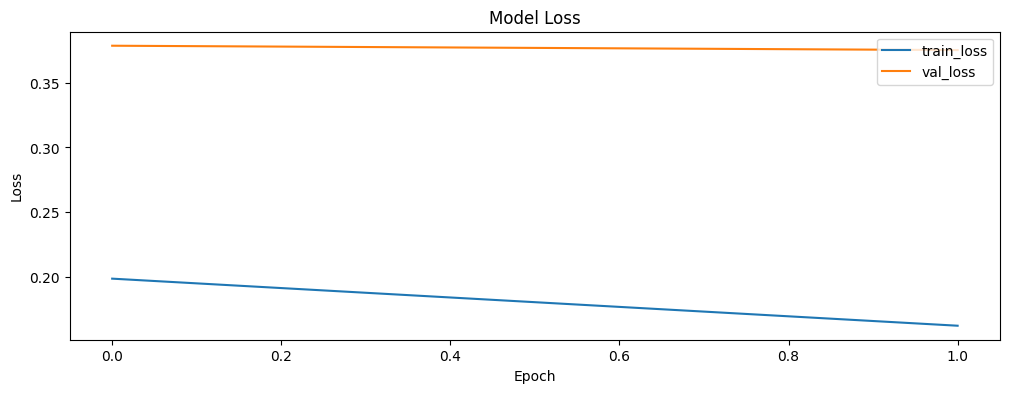

In [42]:
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

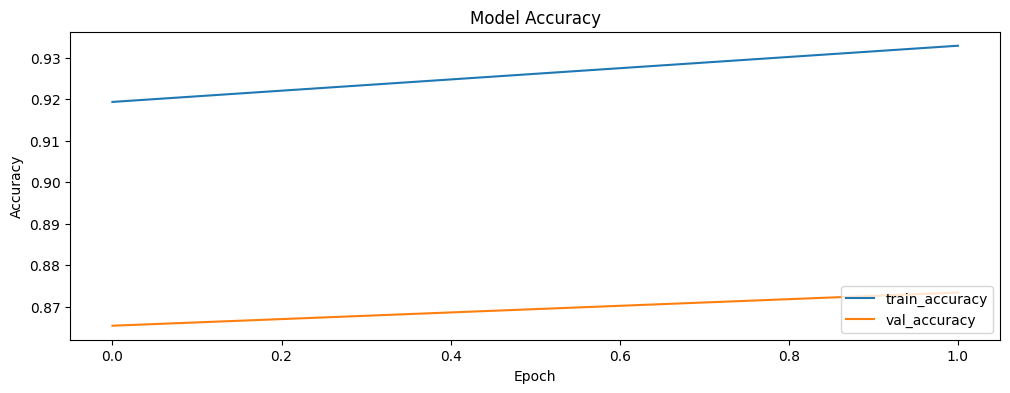

In [43]:
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<h2>Evaluation</h2>

In [40]:
# Get model predictions (probabilities)
y_probs = model.predict(X_test_padded)

# Converting probs into Binary values
y_pred = np.argmax(y_probs, axis=1)

463/463 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step


In [44]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

463/463 ━━━━━━━━━━━━━━━━━━━━ 45s 97ms/step - accuracy: 0.8707 - loss: 0.3880
Loss: 0.38164687156677246, Accuracy: 0.8729729652404785


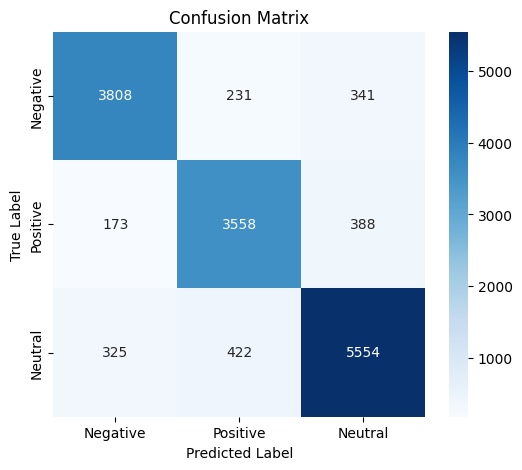

In [45]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [48]:
print( classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4380
           1       0.84      0.86      0.85      4119
           2       0.88      0.88      0.88      6301

    accuracy                           0.87     14800
   macro avg       0.87      0.87      0.87     14800
weighted avg       0.87      0.87      0.87     14800

